## Extração de Característica com Data Augmentation
Agora, vamos implementar a segunda técnica que mencionei para fazer a extração de característica com data augmentation, que é muito mais lenta e cara, mas que permite usar o aumento de dados durante o treinamento: estender o modelo conv_base e executá-lo de ponta a ponta nas entradas.

In [2]:

from tensorflow.keras.applications.vgg16 import VGG16

import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
    
conv_base = VGG16(weights='imagenet',
                    include_top=False,
                    input_shape=(224, 224, 3))
print(conv_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Adicionar um classificador densamente conectado no topo da base convolucional

In [2]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


Como podemos ver, a base convolucional do VGG16 tem 14.714.688 parâmetros, que é muito grande. O classificador que adicionamos tem 2 milhões de parâmetros.

Antes de compilar e treinar o modelo, é muito importante congelar a base convolucional. Congelar uma camada ou conjunto de camadas significa evitar que seus pesos sejam atualizados durante o treinamento. Se você não fizer isso, as representações que foram aprendidas anteriormente pela base convolucional serão modificadas durante o treinamento. Como as camadas Densas na parte superior são inicializadas aleatoriamente, atualizações de peso muito grandes seriam propagadas pela rede, destruindo efetivamente as representações aprendidas anteriormente.

In [3]:
# No Keras, você congela uma rede definindo seu atributo trainable como False:

conv_base.trainable = False


Com esta configuração, apenas os pesos das duas camadas densas adicionamos serão treinados. Isso é um total de quatro tensores de peso: dois por camada (a matriz de peso principal e o vetor de polarização). Observe que para que essas mudanças tenham efeito, você deve primeiro compilar o modelo. Se modificarmos a treinabilidade de peso após a compilação, deverá recompilar o modelo ou essas alterações serão ignoradas.

## Treinar o modelo de ponta a ponta com uma base convolucional congelada 

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
        #fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dataset/train/',
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'dataset/validation/',
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


C:\Users\Avell\AppData\Local\Temp\ipykernel_7264\2257537065.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
100/100 [==============================] - 85s 763ms/step - loss: 0.7462 - acc: 0.7445 - val_loss: 0.3569 - val_acc: 0.8470
Epoch 2/30
100/100 [==============================] - 76s 760ms/step - loss: 0.3861 - acc: 0.8240 - val_loss: 0.2304 - val_acc: 0.8950
Epoch 3/30
100/100 [==============================] - 76s 759ms/step - loss: 0.3072 - acc: 0.8660 - val_loss: 0.2025 - val_acc: 0.9130
Epoch 4/30
100/100 [==============================] - 76s 759ms/step - loss: 0.3079 - acc: 0.8690 - val_loss: 0.1986 - val_acc: 0.9150
Epoch 5/30
100/100 [==============================] - 76s 759ms/step - loss: 0.2928 - acc: 0.8745 - val_loss: 0.2159 - val_acc: 0.9050
Epoch 6/30
100/100 [==============================] - 76s 759ms/step - loss: 0.2823 - acc: 0.8740 - val_loss: 0.1962 - val_acc: 0.9190
Epoch 7/30
100/100 [==============================] - 76s 759ms/step - loss: 0.2651 - acc: 0.8825 - val_loss: 0.2401 - val_acc: 0.9000
Epoch 8/30
100/100 [==============================] - 7

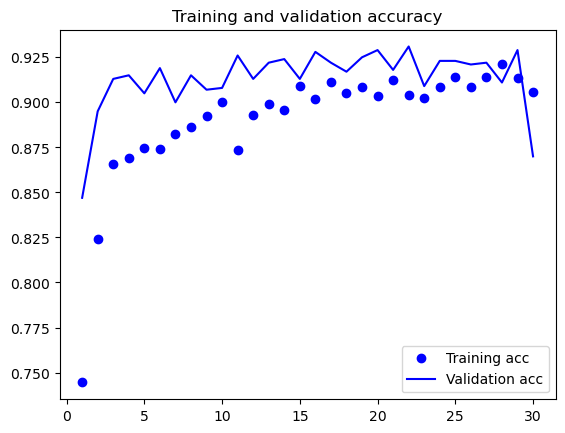

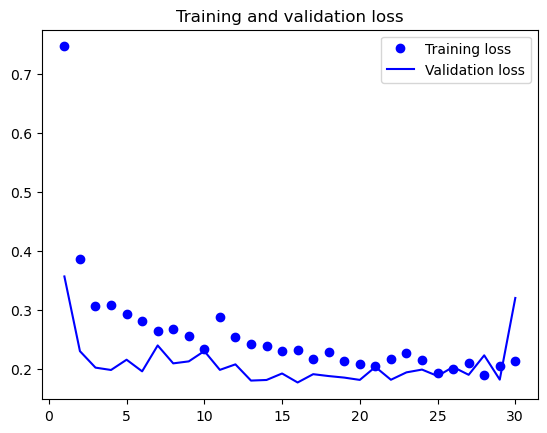

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Ajuste Fino

Outra técnica amplamente usada para reutilização de modelos, complementar à extração de características, é o ajuste fino. O ajuste fino consiste em descongelar algumas das camadas superiores de uma base de modelo congelada usada para extração de características e treinar conjuntamente a parte recém-adicionada do modelo (neste caso, o classificador totalmente conectado) e essas camadas superiores. Isso é chamado de ajuste fino porque ajusta ligeiramente as representações mais abstratas do modelo que está sendo reutilizado, a fim de torná-las mais relevantes para o problema em questão.
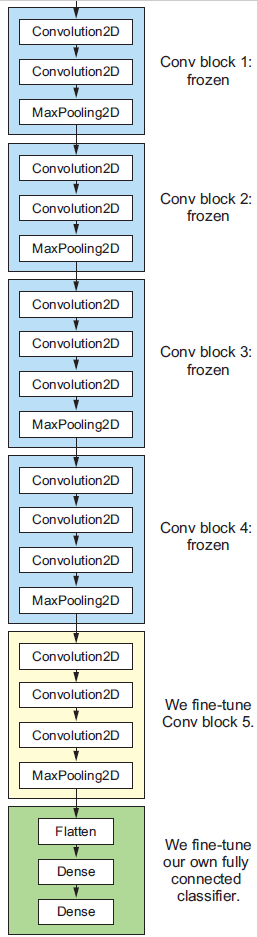

Vimos anteriormente que é necessário congelar a base de convolução do VGG16 para poder treinar um classificador inicializado aleatoriamente no topo. Pelo mesmo motivo, só é possível ajustar as camadas superiores da base convolucional depois que o classificador no topo já tiver sido treinado. Se o classificador ainda não estiver treinado, o sinal de erro que se propaga pela rede durante o treinamento será muito grande e as representações aprendidas anteriormente pelas camadas sendo ajustadas serão destruídas. Assim, as etapas para o ajuste fino de uma rede são as seguintes:

*  Adicione sua rede personalizada em cima de uma rede básica já treinada.
*  Congele a rede básica.
*  Treine a parte que você adicionou.
*  Descongele algumas camadas da rede base.
*  Treine em conjunto essas camadas e a parte que você adicionou.

Nós já concluimos as três primeiras etapas ao fazer a extração de características. Vamos prosseguir com a etapa 4: você irá descongelar sua conv_base e, em seguida, congelar camadas individuais dentro dela.

Iremos fazer o ajuste fino das últimas três camadas convolucionais, o que significa que todas as camadas até block4_pool devem ser congeladas e as camadas block5_conv1, block5_conv2 e block5_conv3 devem ser treináveis.
Por que não ajustar mais camadas? Por que não ajustar toda a base convolucional? Você poderia. Mas você precisa considerar o seguinte:

*  As camadas anteriores na base convolucional codificam recursos mais genéricos e reutilizáveis, enquanto as camadas superiores codificam recursos mais especializados. É mais útil ajustar as características mais especializadas, porque esses são os que precisam ser reaproveitados em seu novo problema. Haveria retornos decrescentes no ajuste fino das camadas inferiores.

*  Quanto mais parâmetros você treina, mais você corre o risco de overfitting. A base convolucional tem 15 milhões de parâmetros, então seria arriscado tentar treiná-la em seu pequeno conjunto de dados. 

## Congelando todas as camadas em uma específica

In [10]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Agora podemos começar a ajustar a rede. Faremos isso com o otimizador RMSProp, usando uma taxa de aprendizado muito baixa. O motivo para usar uma taxa de aprendizado baixa é que desejamos limitar a magnitude das modificações feitas nas representações das três camadas que está ajustando. Atualizações muito grandes podem prejudicar essas representações.

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dataset/train/',
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'dataset/validation/',
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [14]:
model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=2e-5),
                metrics=['acc'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50)

C:\Users\Avell\AppData\Local\Temp\ipykernel_7264\1036818740.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
100/100 [==============================] - 89s 868ms/step - loss: 0.2451 - acc: 0.9055 - val_loss: 0.1657 - val_acc: 0.9390
Epoch 2/30
100/100 [==============================] - 86s 864ms/step - loss: 0.1742 - acc: 0.9285 - val_loss: 0.1303 - val_acc: 0.9520
Epoch 3/30
100/100 [==============================] - 86s 864ms/step - loss: 0.1475 - acc: 0.9405 - val_loss: 0.3565 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 86s 864ms/step - loss: 0.1535 - acc: 0.9380 - val_loss: 0.1475 - val_acc: 0.9320
Epoch 5/30
100/100 [==============================] - 86s 863ms/step - loss: 0.1188 - acc: 0.9525 - val_loss: 0.1163 - val_acc: 0.9520
Epoch 6/30
100/100 [==============================] - 86s 863ms/step - loss: 0.1090 - acc: 0.9610 - val_loss: 0.1152 - val_acc: 0.9490
Epoch 7/30
100/100 [==============================] - 86s 864ms/step - loss: 0.0855 - acc: 0.9675 - val_loss: 0.1198 - val_acc: 0.9580
Epoch 8/30
100/100 [==============================] - 8

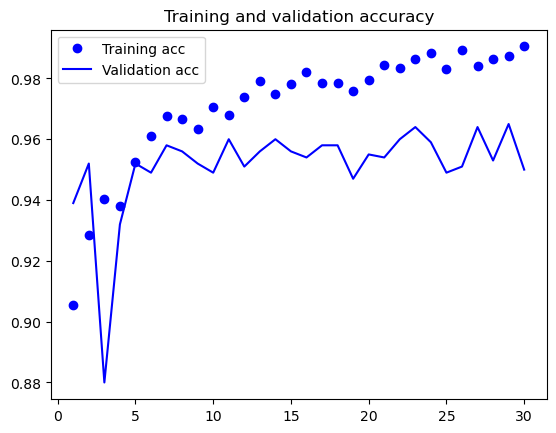

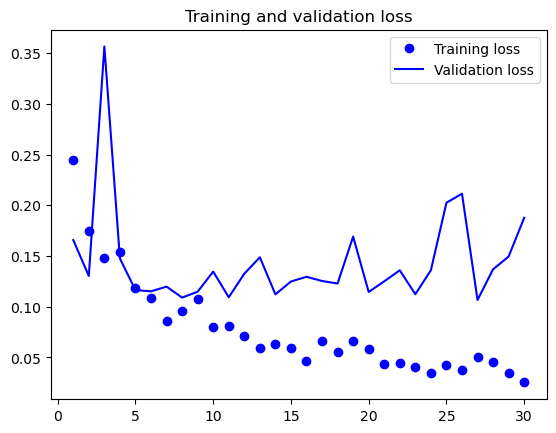

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()